# Задача

Анализ лауреатов нобелевской премии.
*  Извлеч данные по нобелевским лауреатм из общедотсупного источника
*  Найти и проанализировать топ-5 стран по количеству лауреатов

# Подготовка окружения

Задание выполнено в Google Colab, и в этой секции я подтягиваю код напрямую из репозитория.
Проверяющему проект это скорее всего не нужно, можно пропустить эту секцию .

Первичное клонирование репозитория:

In [21]:
!git clone -b my-final-task --single-branch https://github.com/shasha-sh/aaa-final-task.git
%cd aaa-final-task

Cloning into 'aaa-final-task'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 27 (delta 12), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 140.99 KiB | 5.42 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/aaa-final-task/aaa-final-task


Обновление кода с github:

In [23]:
%cd /content/aaa-final-task
!git fetch origin my-final-task
!git checkout my-final-task
!git pull --rebase origin my-final-task

/content/aaa-final-task
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 820 bytes | 410.00 KiB/s, done.
From https://github.com/shasha-sh/aaa-final-task
 * branch            my-final-task -> FETCH_HEAD
   84a605d..7a23e47  my-final-task -> origin/my-final-task
Already on 'my-final-task'
Your branch is behind 'origin/my-final-task' by 1 commit, and can be fast-forwarded.
  (use "git pull" to update your local branch)
From https://github.com/shasha-sh/aaa-final-task
 * branch            my-final-task -> FETCH_HEAD
Updating 84a605d..7a23e47
Fast-forward
 json_dict_processing.py | 29 ++++++++++++++++++++++++++---
 prizes_configs.py       | 20 ++++++++++++++++++--
 2 files changed, 44 insertions(+), 5 deletions(-)


Сброс кэша импортов:

In [22]:
%cd /content/aaa-final-task
import importlib, json_dict_processing, prizes_configs, laureates_configs
importlib.reload(json_dict_processing)
importlib.reload(prizes_configs)
importlib.reload(laureates_configs)

/content/aaa-final-task


<module 'laureates_configs' from '/content/aaa-final-task/laureates_configs.py'>

# Загрузка данных

В этом разделе я подготавливаю данные для анализа :
  1) Получаю данные о лауреатах Нобелевского фонда.
  2) Привожу данные к единому плоскому формату, чтобы дальше с ними было удобно работать.

Необходимые данные находятся публичном API Нобелевского фонда, откуда ответ приходит в формате JSON-словаря. Поэтому данные не требуют сложной предобработки - достаточно проверить базовую корректность структуры ответа.

In [24]:
import requests
URL_LAUREATES = f'https://api.nobelprize.org/2.1/laureates?limit=1200'

laureates_response = requests.get(URL_LAUREATES)
laureates = laureates_response.json()

assert isinstance(laureates, dict)
assert "laureates" in laureates

laureates_list = laureates["laureates"]

assert isinstance(laureates_list, list)
assert len(laureates_list) > 0
assert isinstance(laureates_list[0], dict)
assert all([("knownName" in x) or ("orgName" in x) for x in laureates_list])

Номинантами на премию могут быть люди или организации, и в данных они записаны по-разному. Различаем их по ключам: у людей есть `knownName`, у организаций - `orgName`.  Код проходится по каждому объекту, вспомогательная функция определяет тип записи по этим ключам и приводит её к плоскому, однообразному формату.

**Если какого-то поля в исходных данных нет или оно пустое, в результирующем словаре будет None.**

In [51]:
from laureates_configs import process_orgs, process_persons


def get_laureate_data(laureate: dict) -> dict | None:
    """
    Normalizes a laureate record and labels its type.

    :param laureate: Input laureate dict (from the API).
    :return: Normalized dict with 'laureate_type', or None if undetermined.
    """
    if "knownName" in laureate:
        d = process_persons(laureate)
        d["laureate_type"] = "person"
        return d
    if "orgName" in laureate:
        d = process_orgs(laureate)
        d["laureate_type"] = "org"
        return d
    return None


laureates_data = []

for laureate in laureates['laureates']:
    laureates_data.append(get_laureate_data(laureate))

assert isinstance(laureates_data, list)
assert all((laureate is None) or isinstance(laureate, dict)
                                        for laureate in laureates_data)

 # Формат данных


Перед анализом зафиксируем формат нормализованных данных. Вся информация извлечена на английском языке. В скобках указаны соответствующие пути к полям в исходном JSON.


**Общие поля нормализованных записей**

- `id` — уникальный идентификатор лауреата *(из `id`)*  
- `name` — имя человека или название организации *(из `knownName.en` / `orgName.en`)*  
- `country_now` — современное название страны, где родился человек или где основана организация *(из `birth.place.countryNow.en` / `founded.place.countryNow.en`)*  
- `laureate_type` — тип лауреата: `"person"` или `"org"` *(добавлено на этапе нормализации)*  
- `prizes_relevant` — список призов этого лауреата (см. структуру ниже) *(из `nobelPrizes`, обрабатывается процессором призов)*


**Только для людей** (`laureate_type = "person"`)
- `gender` — пол *(из `gender`)*  
- `birth_year` — год рождения *(год из строки `birth.date`)*  
- `country_birth` — страна рождения *(из `birth.place.country.en`)*


**Только для организаций** (`laureate_type = "org"`)
- `founded_year` — год основания организации *(год из строки `founded.date`)*  
- `country_founded` — страна основания *(из `founded.place.country.en`)*


**Структура элемента в `prizes_relevant`** (каждый элемент — один приз)
- `award_year` — год вручения *(из `awardYear`)*  
- `category_en` — категория приза, напр. _Physics_, _Peace_, _Economic Sciences_ *(из `category.en`)*  
- `prize_amount` — сумма приза на момент вручения *(из `prizeAmount`)*  
- `prize_amount_adjusted` — сумма с поправкой на инфляцию *(из `prizeAmountAdjusted`)*  
- `prize_status` — статус приза *(из `prizeStatus`)*


# Анализ данных


## Вспомогательный функционал для анализа

При анализе понадобится считать несколько независимых метрик. `ops_with_conditions` делает это за один проход по данным, используя заданные списки условий и соответствующие списки названий результатов, операций и селекторов (путей до полей, к которым применяем операцию). Для подсчёта количества (если в `ops` указано `'count'`) применяется только условие из `conditions`, а селектор игнорируется.

Данные на вход:

*  список нормализованных записей (`records`)
*  список предикатов (`conditions`) и такие же по длине списки названий результатов (`labels`), операций (`ops`: допустимые значения только `'count'`, `'sum'`, `'min'`, `'max'`) и селекторов (`selectors`).

Для каждой записи по очереди применяется каждый предикат; если предикат вернул True, к соответствующему результату применяется операция (`count` / `sum` / `min` / `max`).

Ошибки внутри предиката или невозможность выполнить числовую операцию над значением для конкретной записи игнорируются и пропускаются.

Вспомогательные функции

*  `extract(record, selector)` — безопасно извлекает значение из записи про лауреата, если что-то пошло не так, возвращает None без ошибки

*  Операции: `op_count`, `op_sum`, `op_min`, `op_max` - изменяют значения на соответсвующую функцию

Результат — словарь вида *{label: значение}*, где каждое значение соответствует вычесленной операции по соответсвующим полям.

In [52]:
from typing import Callable

def ops_with_conditions(
    records: list[dict[str, object]],
    conditions: list[Callable[[dict[str, object]], bool]],
    labels: list[str],
    ops: list[str],
    selectors: list[str | tuple[str, str]]
) -> dict[str, int | float | list[object]]:
    """
    Run an aggregation per condition.

    For each label you provide:
    - a predicate (record -> bool),
    - an op: "count" | "sum" | "min" | "max"| "union",
    - a selector for non-"count" ops (field name or 2-level path: (k1, k2)).

    Non-numeric selector values are ignored for sum/min/max.

    :param records: Normalized laureate dictionaries.
    :param conditions: Predicates, one per label.
    :param labels: Output names, one per condition.
    :param ops: Operation per label: "count" | "sum" | "min" | "max" | "union".
    :param selectors: Selector per label (ignored conceptually for "count").
    :return: Dict {label: aggregate}.
    """


    def extract(rec: dict[str, object],
                sel: str | tuple[str, str]) -> object | None:
        if isinstance(sel, str):
            return rec.get(sel)
        if isinstance(sel, tuple) and len(sel) == 2:
            outer = rec.get(sel[0])
            if isinstance(outer, dict):
                return outer.get(sel[1])
            return None
        return None


    neutral_el = {
        'min' : float('inf'),
        'max' : float('-inf'),
        'count' : 0,
        'sum' : 0,
        'union' : []
    }


    def op_count(_: dict[str, object],
                 __: str | tuple[str, str],
                 res: int) -> int:
        return res + 1


    def op_sum(rec: dict[str, object],
               sel: str | tuple[str, str],
               res: float | int) -> float | int:
        val = extract(rec, sel)
        return res + (val if isinstance(val, (int, float)) else 0)


    def op_max(rec: dict[str, object],
               sel: str | tuple[str, str],
               res: float) -> float:
        val = extract(rec, sel)
        return max(res, (float(val) if isinstance(val, (int, float))
                                    else neutral_el["max"]))

    def op_min(rec: dict[str, object],
               sel: str | tuple[str, str],
               res: float) -> float:
        val = extract(rec, sel)
        return min(res, (float(val) if isinstance(val, (int, float))
                                    else neutral_el["min"]))


    def op_union(rec: dict[str, object],
                 sel: str | tuple[str, str],
                 res: list[object]) -> list[object]:
        val = extract(rec, sel)
        if val is not None:
            res.append(val)
        return res


    ops_dct = {
        'min' : op_min,
        'max' : op_max,
        'count' : op_count,
        'sum' : op_sum,
        'union' : op_union
    }

    if not (len(labels) == len(conditions) == len(ops) == len(selectors)):
        raise ValueError(
            "conditions, labels, ops, selectors must have the same length"
        )
    for name, op in zip(labels, ops):
        if op not in ops_dct:
            raise ValueError(f"Unsupported op: {op}")

    result = {name: neutral_el[op] for name, op in zip(labels, ops)}

    for rec in records:
        for cond, name, op, selector in zip(conditions, labels, ops, selectors):
            try:
                if cond(rec):
                    result[name] = ops_dct[op](rec, selector, result[name])
            except Exception:
                pass

    return result

## EDA лауреатов

### Анализ количиств различных записей

На прошлом этапе мы работали только с записями, которые относятся к людям и организациям, исследую два конкретных формата словаря. Проверим не упустили ли мы еще что-то.

In [53]:
total_count = ops_with_conditions(
    laureates_data,
    conditions=[lambda d: True, lambda d: d is not None],
    labels=["total", "normalized"],
    ops=["count", "count"],
    selectors=["id", "id"],
)


print(f"Total record count (via counter): {total_count["total"]}")
print(f"Normalized record count (via counter): {total_count["normalized"]}")


Total record count (via counter): 1018
Normalized record count (via counter): 1018


Таким образом количества записей относящихся либо к людям, либо к организациям равно искомому количеству записей, то есть мы нормализовали всех существующих лауреатов. Сохраним это значение.

In [28]:
n = total_count["total"]

Сразу посчитаем количество лауреатов-людей и лауреатов-организаций.

In [33]:
type_counts = ops_with_conditions(
    laureates_data,
    conditions=[
        lambda d: d.get("laureate_type") == "person",
        lambda d: d.get("laureate_type") == "org",
    ],
    labels=["person_count", "org_count"],
    ops=["count", "count"],
    selectors=["id", "id"],
)

print(f"Person record count: {type_counts["person_count"]}")
print(f"Organization record count: {type_counts["org_count"]}")

Person record count: 990
Organization record count: 28


Заметим, что количество лауреатов-людей кратно больше.

### Анализ пропусков в данных

Проверим насколько полная информация у нас о пользователях.

In [66]:
fields = [
    "id", "name", "laureate_type", "country_now",
    "gender", "birth_year", "country_birth",
    "founded_year", "country_founded",
    "prizes_relevant",
]


def run_missing(records, title):
    n = len(records)
    missing_counts = ops_with_conditions(
        records,
        conditions=[(lambda f: (lambda d: (f not in d) or (d.get(f) is None)))(f)
                    for f in fields],
        labels=fields,
        ops=["count"] * len(fields),
        selectors=["id"] * len(fields),
    )
    missing_ratios = {k: (missing_counts[k] / n if n else 0) for k in fields}

    res = {title: f"\n{title} (n={n})\n"}
    for k in fields:
        res[k] = f"{k}: {missing_counts[k]} ({missing_ratios[k]:.3f})\n"

    return res


persons = [d for d in laureates_data if d.get("laureate_type") == "person"]
orgs = [d for d in laureates_data if d.get("laureate_type") == "org"]

print(*[d for d in run_missing(persons, "PERSON").values()])
print(*[d for d in run_missing(orgs, "ORG").values()])



PERSON (n=990)
 id: 0 (0.000)
 name: 0 (0.000)
 laureate_type: 0 (0.000)
 country_now: 3 (0.003)
 gender: 0 (0.000)
 birth_year: 0 (0.000)
 country_birth: 3 (0.003)
 founded_year: 990 (1.000)
 country_founded: 990 (1.000)
 prizes_relevant: 0 (0.000)


ORG (n=28)
 id: 0 (0.000)
 name: 0 (0.000)
 laureate_type: 0 (0.000)
 country_now: 4 (0.143)
 gender: 28 (1.000)
 birth_year: 28 (1.000)
 country_birth: 28 (1.000)
 founded_year: 1 (0.036)
 country_founded: 4 (0.143)
 prizes_relevant: 0 (0.000)



Пропуски в `gender`, `birth_year`, `country_birth` и в`founded_year`, `country_founded` полностью объяняются тем, что эти поля неприменимы либо к людям, либо к организациям. Реальные неполные данные:
*  3 человека без `country_birth`
*  3 человека без `country_now`
*  4 организации без `country_now`
*  1 организация без `founded_year`
*  4 организации без `country_founded`

In [67]:
without_country_birth = [d for d in persons if d.get("country_birth") is None]
for d in without_country_birth:
    print(f"ID: {d['id']}\n"
          f"Name: {d['name']}\n"
          f"Country birth: {d['country_birth']}\n"
          f"Country now: {d['country_now']}\n"
          f"Award year: {d['prizes_relevant'][0]['award_year']}\n")

ID: 1004
Name: Abdulrazak Gurnah
Country birth: None
Country now: None
Award year: 2021

ID: 1046
Name: James A. Robinson
Country birth: None
Country now: None
Award year: 2024

ID: 1052
Name: John M. Martinis
Country birth: None
Country now: None
Award year: 2025



Нашли три лаурята без записи о стране рождения. Заметим, что страны проживания провпущены у них же. Три недавних лаурята вообще без данных о стране. Это реальные неполные данные, не структурные пропуски. С помощью поиска в интернете я восстановила их страны.

In [68]:
updates = {
    "1004": {"country_birth": "Tanzania",
             "country_now": "United Kingdom"},

    "1046": {"country_birth": "United Kingdom",
             "country_now": "United States"},

    "1052": {"country_birth": "United States",
             "country_now": "United States"},
}

for d in laureates_data:
    if d["id"] in updates:
        d.update(updates[d["id"]])

for d in persons:
    if d["id"] in updates:
        d.update(updates[d["id"]])

Аналогично рассмотрим организации

In [69]:
without_country_founded = [d for d in orgs if d.get("country_founded") is None]
for d in without_country_founded:
    print(f"ID: {d['id']}\n"
          f"Name: {d['name']}\n"
          f"Country founded: {d['country_founded']}\n"
          f"Country now: {d['country_now']}\n"
          f"Founded year: {d['founded_year']}\n"
          f"Award year: {d['prizes_relevant'][0]['award_year']}\n")

ID: 881
Name: European Union
Country founded: None
Country now: None
Founded year: 1952
Award year: 2012

ID: 925
Name: National Dialogue Quartet
Country founded: None
Country now: None
Founded year: None
Award year: 2015

ID: 893
Name: Organisation for the Prohibition of Chemical Weapons
Country founded: None
Country now: None
Founded year: 1997
Award year: 2013

ID: 994
Name: World Food Programme
Country founded: None
Country now: None
Founded year: 1961
Award year: 2020



*European Union*, *Organisation for the Prohibition of Chemical Weapons* и *World Food Programme* международные организация, так что пропуски полей корректны.

*National Dialogue Quartet* - это коалиция организаций Туниса, т.е. фактически национальная организация. Однако она действительно не имеет года основания и пропуск корректный.

In [70]:
org_updates = {
    "925": {
        "country_founded": "Tunisia",
        "country_now": "Tunisia",
    }
}

for d in laureates_data:
    if d["laureate_type"] == "org" and d["id"] in org_updates:
        d.update(org_updates[d["id"]])

for d in orgs:
    if d["laureate_type"] == "org" and d["id"] in org_updates:
        d.update(org_updates[d["id"]])

In [82]:
new_persons_stat = run_missing(persons, "PERSON")

assert new_persons_stat['country_birth'].split()[1] == "0"
assert new_persons_stat['country_now'].split()[1] == "0"

new_orgs_stat = run_missing(orgs, "ORG")
print(new_orgs_stat['country_now'], new_orgs_stat['country_founded'], new_orgs_stat['founded_year'])

assert new_orgs_stat['country_now'].split()[1] == "3"
assert new_orgs_stat['country_founded'].split()[1] == "3"
assert new_orgs_stat['founded_year'].split()[1] == "1"

country_now: 3 (0.107)
 country_founded: 3 (0.107)
 founded_year: 1 (0.036)



### Анализ id лауреатов

Теперь рассмотрим формат id лауреатов.

In [85]:
ids_res = ops_with_conditions(
    laureates_data,
    conditions=[lambda d: True],
    labels=["ids"],
    ops=["union"],
    selectors=["id"]
)

assert all([id.isdigit() for id in ids_res["ids"]])

ids = [int(id) for id in ids_res["ids"]]


Получили, что все id в строковом формате данных, однако спокойно кастятся к числовому формату. Для удобства так и сделаем.


Проверим есть ли записи с повторяющимися id.

In [87]:
from collections import Counter


cnt = Counter(ids)
duplicates = {k: v for k, v in cnt.items() if v > 1}
print("Duplicate IDs:", duplicates if duplicates else "no duplicates")

Duplicate IDs: no duplicates


Дупликатов нет. Соответсвенно если один человек или организация номинировались несколько раз, им давали новый id.

Рассмотрим связь самого большого и маленького id.

In [86]:
min_id = min(ids)
max_id = max(ids)

def prize_years_for(laureates, target_id: int) -> list[int]:
    years: set[int] = set()
    t = str(target_id)
    for rec in laureates:
        if str(rec.get("id")) == t:
            for p in rec.get("prizes_relevant") or []:
                y = p.get("award_year")
                if isinstance(y, int):
                    years.add(y)
    return sorted(years)

min_id_years = prize_years_for(laureates_data, min_id)
max_id_years = prize_years_for(laureates_data, max_id)

print(f"Min id: {min_id}, award years: {min_id_years}")
print(f"Max id: {max_id}, award years: {max_id_years}")

Min id: 1, award years: [1901]
Max id: 1060, award years: [2025]


Самый большой и маленький id соответсвуют годам хронологически.


Рассмотрим связь id и года наминации. Начнём с проверки на наличие лаурятов с несколькими призами.

In [104]:
for d in laureates_data:
    if len(d.get("prizes_relevant") or []) > 1:
        name = d['name']
        years = [p.get("award_year") for p in (d.get("prizes_relevant") or [])]
        print(name, years)

Frederick Sanger [1958, 1980]
International Committee of the Red Cross [1917, 1944, 1963]
John Bardeen [1956, 1972]
K. Barry Sharpless [2001, 2022]
Linus Pauling [1954, 1962]
Marie Curie [1903, 1911]
Office of the United Nations High Commissioner for Refugees [1954, 1981]


Да, такие конечно же есть. Тогда будем брать минимальный год - то есть тот год, в который id появился впервые.

In [111]:
ids_sorted = sorted(ids)
gaps = []
for prev, curr in zip(ids_sorted, ids_sorted[1:]):
    if curr - prev > 1:
        gaps.append((prev, curr))

print("Gaps between sorted IDs:", *sorted(gaps) if gaps else "no gaps", sep='\n')

Gaps between sorted IDs:
(6, 8)
(93, 95)
(169, 172)
(255, 257)
(468, 470)
(503, 505)
(520, 523)
(541, 543)
(569, 571)
(590, 592)
(594, 596)
(597, 600)
(610, 613)
(615, 617)
(631, 633)
(635, 637)
(645, 647)
(655, 657)
(783, 786)
(787, 789)
(858, 861)
(896, 903)
(949, 958)
(1009, 1011)


Пропусков достаточно много. Посмотрим уже на наличие линейной зависимости.

In [112]:
pairs = []
for d in laureates_data:
    years = [
        p.get("award_year")
        for p in (d.get("prizes_relevant") or [])
    ]
    if years:
        pairs.append((min(years), int(d["id"])))

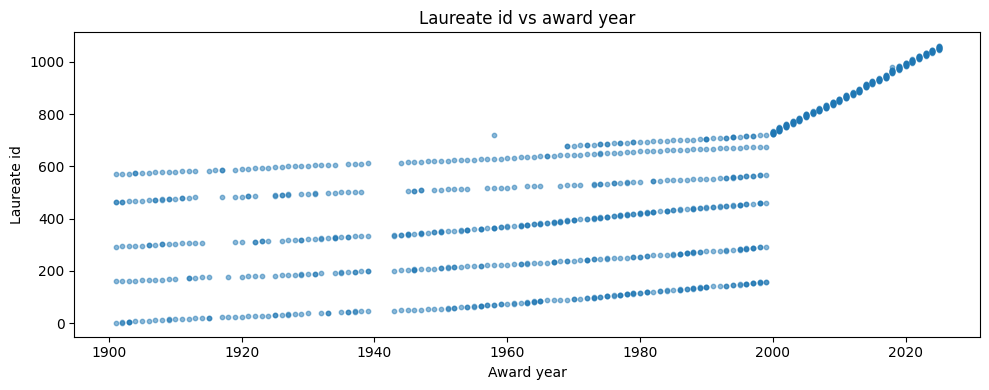

In [113]:
import matplotlib.pyplot as plt


award_years = [y for y, _ in pairs]
ids = [i for _, i in pairs]

plt.figure(figsize=(10, 4))
plt.scatter(award_years, ids, s=10, alpha=0.5)
plt.xlabel("Award year")
plt.ylabel("Laureate id")
plt.title("Laureate id vs award year")
plt.tight_layout()
plt.show()

Какие-то внутринние линейные зависимости видны, осталось понять с чем они связаны. Так как до 2000-ого года различимо 6 параллельных линий сразу приходит в голову проверить связь с категориями премий.

Сразу посмотрим, какие вообще премии существуют.

In [172]:
categories = sorted({
    p.get("category_en")
    for d in laureates_data
    for p in (d.get("prizes_relevant") or [])
    if p.get("category_en") is not None
})

for i, cat in enumerate(categories):
    print(f"{i + 1}. {cat}")

1. Chemistry
2. Economic Sciences
3. Literature
4. Peace
5. Physics
6. Physiology or Medicine


In [119]:
points = []
for d in laureates_data:
    first_prize = min(d["prizes_relevant"], key=lambda p: p["award_year"])
    points.append((first_prize["award_year"], int(d["id"]), first_prize["category_en"]))


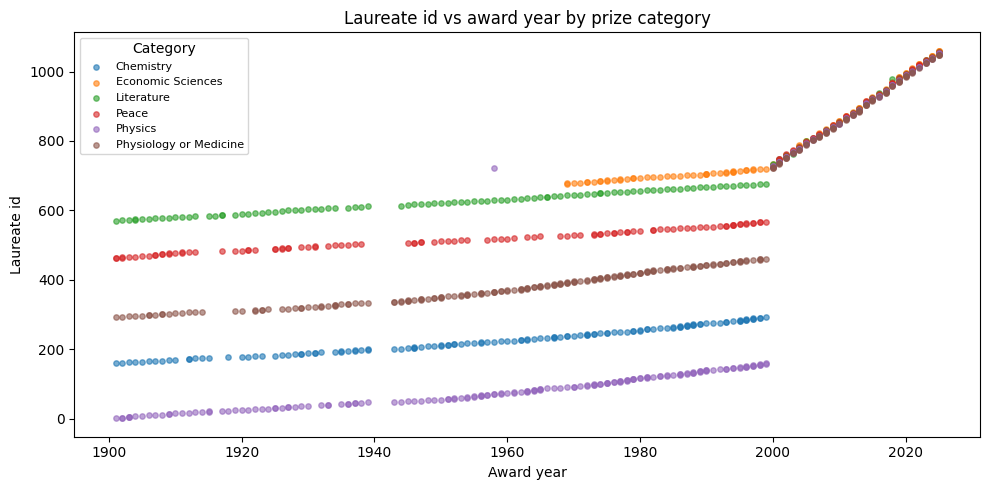

In [120]:
plt.figure(figsize=(10, 5))

for cat in categories:
    xs = [y for y, i, c in points if c == cat]
    ys = [i for y, i, c in points if c == cat]
    plt.scatter(xs, ys, label=cat, alpha=0.6, s=15)

plt.xlabel("Award year")
plt.ylabel("Laureate id")
plt.title("Laureate id vs award year by prize category")
plt.legend(title="Category", fontsize=8)
plt.tight_layout()
plt.show()

До ~2000 года значения id в данных выглядят как присвоенные блоками по категориям линейно. После ~2000 наблюдается переход к единому линейному порядку присвоения id для всех категорий (категории сливаются в одну линию). Можно предположить, что id - технический идентификатор источника и его схема могла изменяться со временем.

Можно заметить явно выбивающуюся фиолетовую точку над всеми параллельными линиями. Попробуем выяснить кто это.

In [153]:
physics_befor_2000 = []
for d in laureates_data:
    first_prize = min(d["prizes_relevant"], key=lambda p: p["award_year"])
    if (first_prize["category_en"] == "Physics"
                              and first_prize["award_year"] < 2000):
        physics_befor_2000.append({
            'ID': d['id'],
            'Name': d["name"],
            'Award year': first_prize["award_year"],
            'Awards count': len(d["prizes_relevant"]),
        })


cand = sorted(physics_befor_2000, key=lambda x: int(x['ID']))

for d in cand[-3:]:
    for k, v in d.items():
        print(f"{k}: {v}")
    print()

ID: 158
Name: Gerardus 't Hooft
Award year: 1999
Awards count: 1

ID: 159
Name: Martinus J.G. Veltman
Award year: 1999
Awards count: 1

ID: 721
Name: Il´ja M. Frank
Award year: 1958
Awards count: 1



Илья Михайлович Франк единственный из всех физиков с таким большим ID. По информации из интернета премию он получил совместо с другими двумя советскими учеными.

In [155]:
laureates_1958 = [
    (d["id"], d["name"])
    for d in laureates_data
    if any(
        p["award_year"] == 1958 and p["category_en"] == "Physics"
        for p in d["prizes_relevant"]
    )
]
for k, v in laureates_1958:
    print(f"{k}: {v}")
print()

71: Igor Y. Tamm
721: Il´ja M. Frank
70: Pavel A. Cherenkov



Это и есть коллеги, с которыми он получил премию. Видимо, мы поймали какой-то сбой в их базе.

### Анализ годов без премии

Также на графике видны явные пропуски среди годов. Рассмотрим года, в которые премия не вручалась.

Во-первых видно что премия по экономике сильно моложе остальных. Посмотрим в каком году она появилась.

In [157]:
min(
    [
        p["award_year"]
        for d in laureates_data
        for p in d["prizes_relevant"]
        if p["category_en"] == "Economic Sciences"

    ]
)

1969

Теперь расмотрим в какие года не было премий вообще.

In [160]:
all_years = set(range(1901, 2026))
awarded_any = {
    p["award_year"]
    for d in laureates_data
    for p in d["prizes_relevant"]
}

awarded_without_received = {
    p["award_year"]
    for d in laureates_data
    for p in d["prizes_relevant"]
    if p.get("prize_status") == "received"
}


missing_any = sorted(all_years - awarded_any)
missing_received = sorted(all_years - awarded_received)

print("Missing years (any status):", missing_any)
print("Missing years (without received only):", missing_received)


Missing years (any status): [1940, 1941, 1942]
Missing years (received only): [1940, 1941, 1942]


Я ожидала также увидеть года первой мировой войны. Посмотрим, что происходит в различных категориях.

In [182]:
awarded_any_by_cat = {}

for cat in categories:
    awarded_any_by_cat[cat] = {
        p["award_year"]
        for d in laureates_data
        for p in d["prizes_relevant"]
        if p["category_en"] == cat
    }

awarded_without_received_by_cat = {}

for cat in categories:
    awarded_without_received_by_cat[cat] = {
        p["award_year"]
        for d in laureates_data
        for p in d["prizes_relevant"]
        if p["category_en"] == cat and p["prize_status"] == "received"

    }

missing_any_by_cat = {
    cat: sorted(all_years - years)
    for cat, years in awarded_any_by_cat.items()
}

missing_without_received_by_cat = {
    cat: sorted(all_years - years)
    for cat, years in awarded_without_received_by_cat.items()
}

count_mismatches = 0
for cat in categories:
    print(cat)
    if not(missing_any_by_cat[cat]
                            == missing_without_received_by_cat[cat]):
      print("---MISMATCHES---")
    if cat == 'Economic Sciences':
        print("  missing (any):", sorted(set(missing_any_by_cat[cat])
              - set(range(1901, 1969))))
        print("  missing (without received):", sorted(set(missing_without_received_by_cat[cat])
              - set(range(1901, 1969))))
        continue
    print("  missing (any):", missing_any_by_cat[cat])
    print("  missing (without received):", missing_without_received_by_cat[cat])

Chemistry
  missing (any): [1916, 1917, 1919, 1924, 1933, 1940, 1941, 1942]
  missing (without received): [1916, 1917, 1919, 1924, 1933, 1940, 1941, 1942]
Economic Sciences
  missing (any): []
  missing (without received): []
Literature
---MISMATCHES---
  missing (any): [1914, 1918, 1935, 1940, 1941, 1942, 1943]
  missing (without received): [1914, 1918, 1935, 1940, 1941, 1942, 1943, 1958, 1964]
Peace
  missing (any): [1914, 1915, 1916, 1918, 1923, 1924, 1928, 1932, 1939, 1940, 1941, 1942, 1943, 1948, 1955, 1956, 1966, 1967, 1972]
  missing (without received): [1914, 1915, 1916, 1918, 1923, 1924, 1928, 1932, 1939, 1940, 1941, 1942, 1943, 1948, 1955, 1956, 1966, 1967, 1972]
Physics
  missing (any): [1916, 1931, 1934, 1940, 1941, 1942]
  missing (without received): [1916, 1931, 1934, 1940, 1941, 1942]
Physiology or Medicine
  missing (any): [1915, 1916, 1917, 1918, 1921, 1925, 1940, 1941, 1942]
  missing (without received): [1915, 1916, 1917, 1918, 1921, 1925, 1940, 1941, 1942]


Заметим, что единственная премия от который отказывались - это премия по Литературе. На самом деле случаи достаточно известные, поэтому позволю себе не перепроверять на данных.
*  В 1958 Пастернак отказался из-за давления советских властей
*  В 1964 Сартр откался по личным принципам


Также заметим, что премия по экономике вручалась во все года с момента её появления.

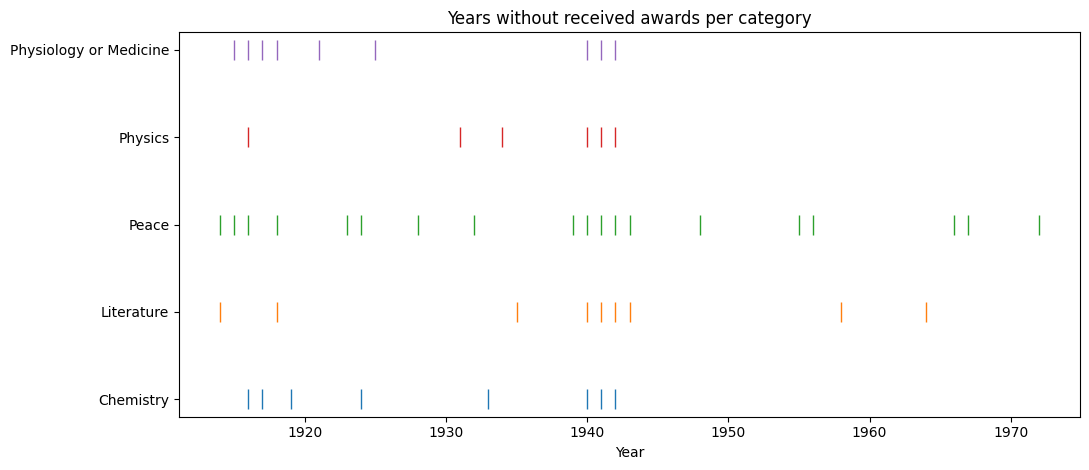

In [184]:
cats = [c for c in categories if c != "Economic Sciences"]
ypos = {cat: i for i, cat in enumerate(cats)}

plt.figure(figsize=(11, 4.8))

for cat in cats:
    xs = missing_without_received_by_cat[cat]
    ys = [ypos[cat]] * len(xs)
    plt.scatter(xs, ys, marker="|", s=220, linewidths=1)

plt.yticks(range(len(cats)), cats)
plt.xlabel("Year")
plt.title("Years without received awards per category")
plt.tight_layout()
plt.show()

Премии не вручались в ближайшие годы к мировым войнам. Больше всего пропуском у премии Мира.

### Анализ стран лауреатов

In [203]:
country_fields = ["country_birth", "country_now", "country_founded"]


countries_all = sorted({
    d.get(f)
    for d in laureates_data
    for f in country_fields
    if d.get(f)
})
countries_all

['Algeria',
 'Argentina',
 'Australia',
 'Austria',
 'Austria-Hungary',
 'Austrian Empire',
 'Azerbaijan',
 'Bangladesh',
 'Bavaria',
 'Belarus',
 'Belgian Congo',
 'Belgium',
 'Bosnia',
 'Bosnia and Herzegovina',
 'Brazil',
 'British India',
 'British Mandate of Palestine',
 'British Protectorate of Palestine',
 'British West Indies',
 'Bulgaria',
 'Burma',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Crete',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Czechoslovakia',
 'Democratic Republic of the Congo',
 'Denmark',
 'East Friesland',
 'East Timor',
 'Egypt',
 'Ethiopia',
 'Faroe Islands (Denmark)',
 'Finland',
 'France',
 'Free City of Danzig',
 'French Algeria',
 'French protectorate of Tunisia',
 'German-occupied Poland',
 'Germany',
 'Ghana',
 'Gold Coast',
 'Greece',
 'Guadeloupe, France',
 'Guatemala',
 'Hesse-Kassel',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Java, Dutch East Indies',
 'Jordan

В списке стран много дублирующихся и исторически разных названий, поэтому прямое сравнение частот по странам искажено. Ситуация особенно сложная для Африки из-за колониальных названий, которые могут соответствовать современным государствам неоднозначно. В рамках подготовки данных я исправлю наиболее очевидные кейсы (синонимы и переименования).

In [204]:
COUNTRY_MAP = {
    "USA": "United States",
    "the Netherlands": "Netherlands",
    "Persia": "Iran",
    "West Germany": "Germany",
    "Russian Empire": "Russia",
    "USSR": "Russia",
}

FIELDS = ["country_birth", "country_now", "country_founded"]

def normalize_country(x):
    return COUNTRY_MAP.get(x, x)

for d in laureates_data:
    for f in FIELDS:
        d[f] = normalize_country(d.get(f))


## Топ-5 стран по числу лауреатов

In [205]:
def draw_top(condition, cat_name):
    countries_res = ops_with_conditions(
        laureates_data,
        conditions=[condition],
        labels=["countries"],
        ops=["union"],
        selectors=["country_now"],
    )
    countries = [c for c in countries_res["countries"] if c]
    top5 = Counter(countries).most_common(5)


    x = [name for name, _ in top5]
    y = [cnt for _, cnt in top5]

    plt.figure()
    plt.bar(x, y)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Top-5 countries {cat_name}")
    plt.tight_layout()
    plt.show()

Сначала подведем общий топ по всем номинациям.

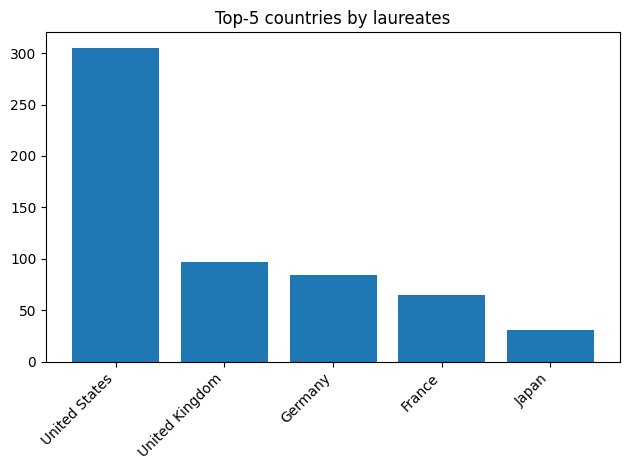

In [206]:
draw_top(lambda d: True, "by laureates")

Теперь посмотрив в разрезе на несколько номинаций. Считаем лауреатов, которые имеют хотя бы один приз в соответсвующей категории.

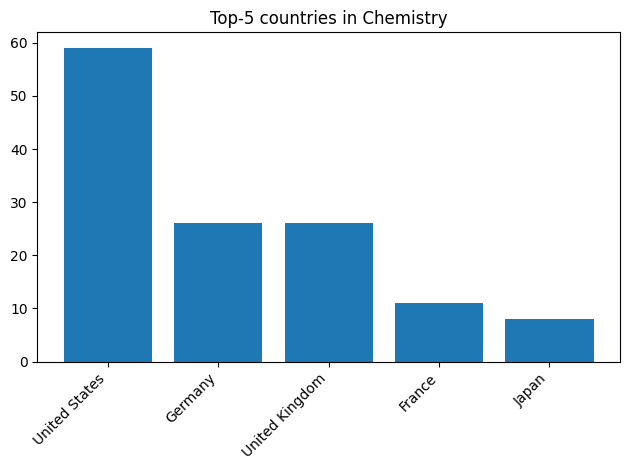

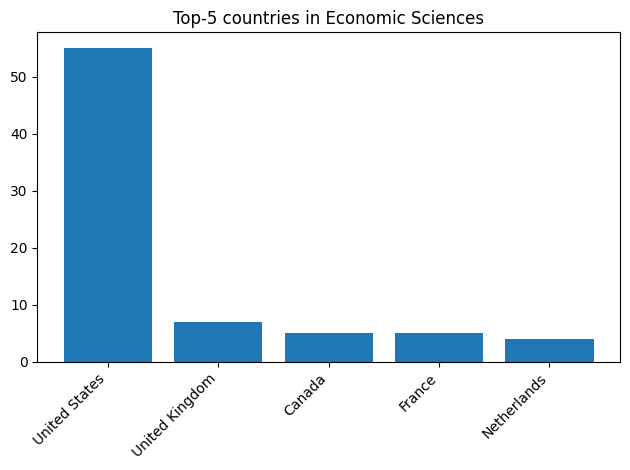

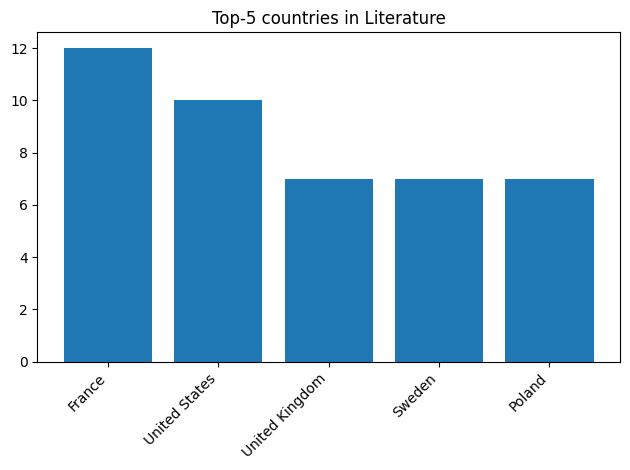

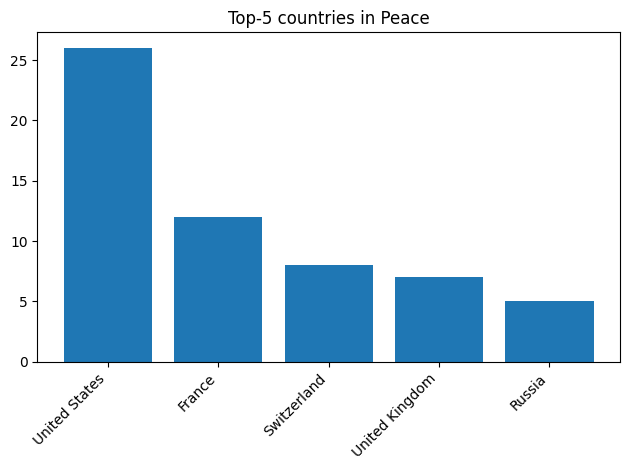

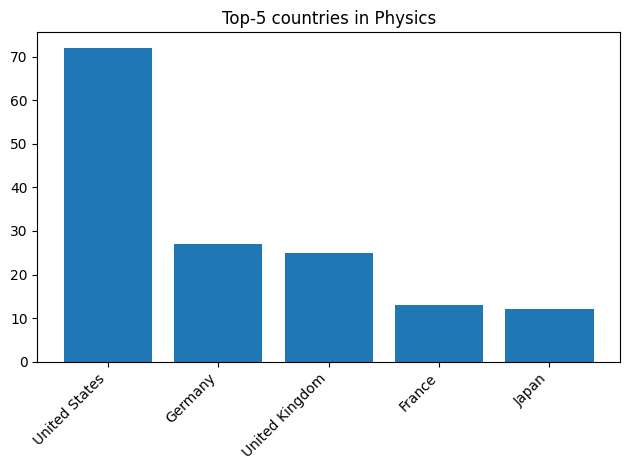

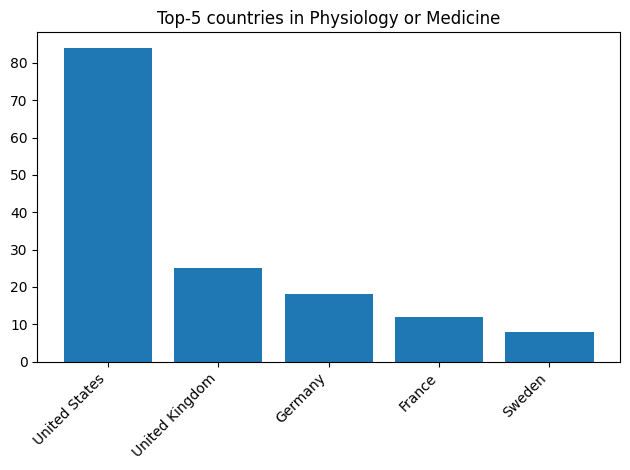

In [207]:
cats = ['Chemistry', 'Economic Sciences', 'Literature', 'Peace', 'Physics', 'Physiology or Medicine']

for cat in cats:
  draw_top(
      lambda d: any(
          p.get("category_en") == cat
          for p in (d.get("prizes_relevant") or [])
      ),
      "in " + cat)

**Вывод:**
*  **В целом** топ-1 по числу лауреатов - это США (с большим отрывом), затем Великобритания, Германия, Франция и Япония.

*  **Экономические науки**: лидируют США с большим отрывом, остальные страны значительно позади.

*  **Химия**: лидируют США, далее Германия и Великобритания, у Франции и Японии заметно меньше лауреатов.

*  **Физиология и медицина**: лидируют США; Великобритания и Германия также имеют значительную долю среди лауреатов.

*  **Физика**: лидируют США, далее Германия и Великобритания, затем Франция и Япония.

*  **Литература**: лидирует Франция, США занимают второе место; далее следуют Великобритания, Швеция и Польша. Это единственная премия, где США не занимают первое место.

*  **Премия мира**: лидируют США; также в топ входят Франция, Швейцария, Великобритания и Россия.



## Многократные лауреаты

Вернёмся к анализу многократных лауреатов. Посчитаем сколько их.

In [188]:
multiple_laureates = []

for d in laureates_data:
    if len(d.get("prizes_relevant") or []) > 1:
        multiple_laureates.append(d)

print(f"Number of laureates: {len(multiple_laureates)}")

Number of laureates: 7


Посмотрим, сколько премий многократные лауреаты получали.


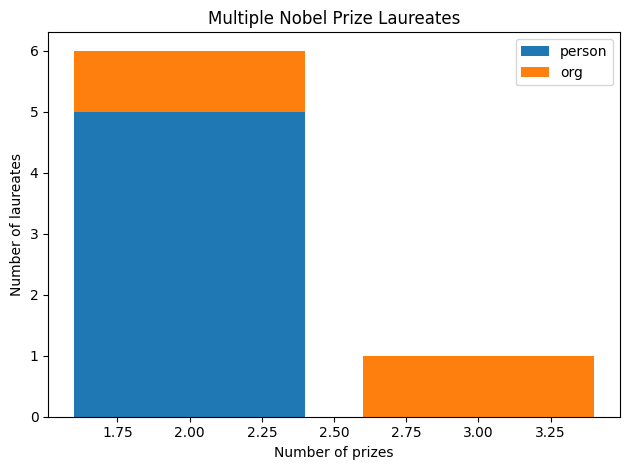

In [191]:
counts = Counter(
    (d["laureate_type"], len(d["prizes_relevant"]))
    for d in multiple_laureates
)

xs = sorted({n for _, n in counts})

plt.figure()
plt.bar(xs, [counts.get(("person", x), 0) for x in xs], label="person")
plt.bar(xs, [counts.get(("org", x), 0) for x in xs],
        bottom=[counts.get(("person", x), 0) for x in xs],
        label="org")

plt.xlabel("Number of prizes")
plt.ylabel("Number of laureates")
plt.title("Multiple Nobel Prize Laureates")
plt.legend()
plt.tight_layout()
plt.show()


Среди многократных лауреатов 5 людей и 2 организации.

Только один случай в истории, когда лауреат получил 3 премии. И это:

In [189]:
for d in multiple_laureates:
    if len(d.get("prizes_relevant")) == 3:
        print(d["name"])

International Committee of the Red Cross


Посмотрим на совпадение категорий второго приза с первым. По прошлому пункту знаем, что организации получают только премию Мира, поэтому не рассматриваем их.

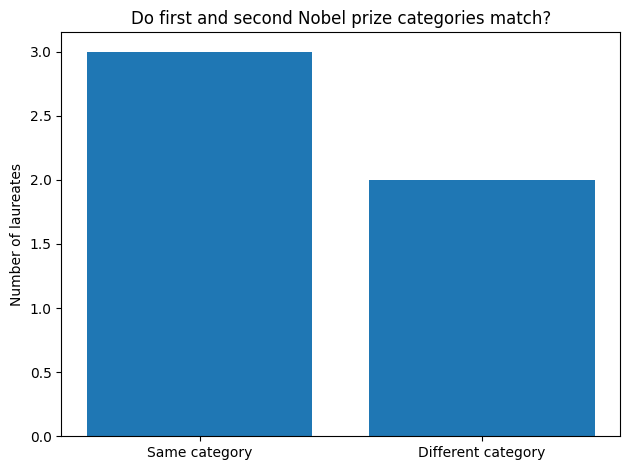

In [198]:
same, diff = 0, 0

for d in multiple_laureates:
    prizes = d.get("prizes_relevant") or []
    if d["laureate_type"] == "person":
        prizes = sorted(prizes, key=lambda p: p["award_year"])
        if prizes[0]["category_en"] == prizes[1]["category_en"]:
            same += 1
        else:
            diff += 1

plt.bar(["Same category", "Different category"], [same, diff])
plt.ylabel("Number of laureates")
plt.title("Do first and second Nobel prize categories match?")
plt.tight_layout()
plt.show()


Соотношение примерно равное.

In [201]:
gaps = []
for d in multiple_laureates:
    years = sorted(p["award_year"] for p in d["prizes_relevant"])
    gaps.append(years[1] - years[0])

avg_gap = sum(gaps) / len(gaps)
print(f"Min gap: {min(gaps)}\n"
      f"AVG gap: {round(avg_gap, 2)}\n"
      f"Max gap: {max(gaps)}\n")

Min gap: 8
AVG gap: 18.43
Max gap: 27



Интервалы между первой и второй наградами варьируются от 8 до 27 лет, со средним значением около 18 лет. Таким образом еще не было случаев, чтобы повторное получение происходило близко к первому.